# RSNA Bone Age

In [1]:
import pandas as pd
import numpy as np

from os import listdir, mkdir, rename, makedirs
from os.path import isfile, join, isdir

from sklearn.utils import shuffle

import matplotlib.pyplot as plt
import seaborn as sns

import keras
from keras import layers, models, regularizers, optimizers
from keras import backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications import Xception
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model, Sequential
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [2]:
train_val = pd.read_csv('./rsna-bone-age/boneage-training-dataset.csv', index_col='id')
test = pd.read_csv('./rsna-bone-age/test.csv', index_col='id')

In [3]:
train_val.shape, test.shape

((12611, 2), (200, 2))

In [22]:
train_val.describe()

,id,boneage
count,12611.000000,12611.000000
mean,8537.653001,127.320752
std,4108.763993,41.182021
min,1377.000000,1.000000
25%,5074.500000,96.000000
50%,8565.000000,132.000000
75%,12091.500000,156.000000
max,15610.000000,228.000000


## Descriptives of the dataset

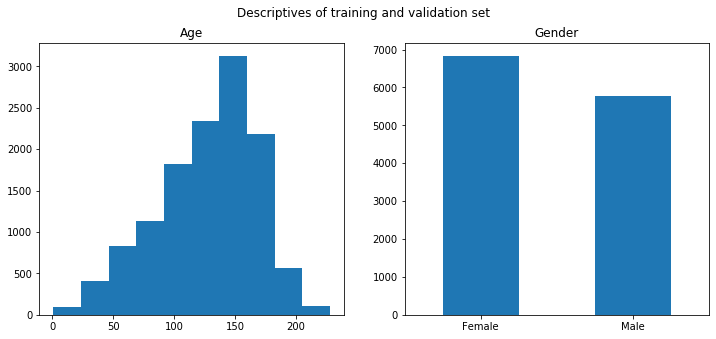

In [4]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of training and validation set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train_val['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
train_val['male'].value_counts().plot(kind='bar', title='Gender')
plt.xticks([True, False], ['Male', 'Female'], rotation='horizontal');

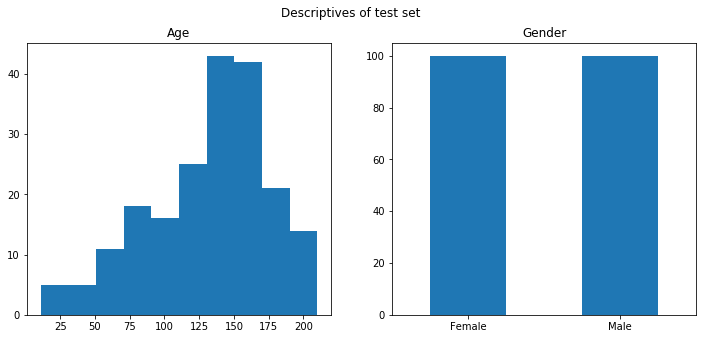

In [5]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of test set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(test['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
test['male'].value_counts().plot(kind='bar', title='Gender')
plt.xticks([True, False], ['Male', 'Female'], rotation='horizontal');

## Add image path to df

In [9]:
def imgs_path(df, typ):
    """
    Function to add the image path to df
    """
    
    path = './rsna-bone-age/boneage-{}-dataset/'.format(typ)
    df['img_path'] = None
    for img in listdir(path):
        if img.endswith('.png'):
            img_path = path + img 
            df.loc[(int(img.strip('.png'))), 'img_path'] = img_path
    return df

In [10]:
train_val = imgs_path(train_val, 'training')
test = imgs_path(test, 'test')

In [11]:
train_val.shape, test.shape

((12611, 3), (200, 3))

### Resizing and Padding
Code for the resize and padding function was taken from: https://jdhao.github.io/2017/11/06/resize-image-to-square-with-padding/

In [12]:
import sys
import cv2

def resize_padding_img(img_path, desired_size):
    """
    Function to resize the image with padding
    """
    
    desired_size = desired_size
    im_pth = img_path

    im = cv2.imread(im_pth)
    old_size = im.shape[:2] # old_size is in (height, width) format

    ratio = float(desired_size)/max(old_size)
    new_size = tuple([int(x*ratio) for x in old_size])

    # new_size should be in (width, height) format

    im = cv2.resize(im, (new_size[1], new_size[0]))

    delta_w = desired_size - new_size[1]
    delta_h = desired_size - new_size[0]
    top, bottom = delta_h//2, delta_h-(delta_h//2)
    left, right = delta_w//2, delta_w-(delta_w//2)

    color = [0, 0, 0]
    new_im = cv2.copyMakeBorder(im, top, bottom, left, right, cv2.BORDER_CONSTANT, value=color)

    return new_im

def resize_padding_set(df, img_set, desired_size, save):
    """
    Function to resize the entire set of images with padding and save to a desired path
    """
    
    # Create directory for resized and padded images
    dirname = './rsna-bone-age/resized_padded/{}'.format(img_set)
    if save:
        makedirs(dirname)
    
    # Create extra column in df to save path to resized and padded image
    df['rp_img_path'] = None
    
    for index, row in df.iterrows():
        # Resizing and padding
        img_path = row['img_path']
        if save:
            rp_img = resize_padding_img(img_path, desired_size)
        
        # Write resized and padded images to disk
        filename = '{}.jpg'.format(index)
        if save:    
            cv2.imwrite(dirname + '/' + filename, rp_img) 
        
        # Save path to resized and padded image to df
        df.loc[index, 'rp_img_path'] = dirname + '/' + filename
        
    return df

In [14]:
train_val = resize_padding_set(train_val, 'training', 100, False)
test = resize_padding_set(test, 'test', 100, False)

In [15]:
train_val.shape, test.shape

((12611, 4), (200, 4))

## Split data into training and validation
Code is inspired by https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age

### Cut bone age regression data into 10 categories to stratify on

In [17]:
train_val.reset_index(inplace=True)

In [18]:
train_val['boneage_category'] = pd.cut(train_val['boneage'], 10)

In [19]:
from sklearn.model_selection import train_test_split
raw_train, validation = train_test_split(train_val, 
                                   test_size = 0.25, 
                                   random_state = 0,
                                   stratify = train_val['boneage_category'])
print('Number of images in training set: ', raw_train.shape[0])
print('Number of images in validation set: ', validation.shape[0])

Number of images in training set:  9458
Number of images in validation set:  3153


## Balance distribution in training set
Code is inspired by https://www.kaggle.com/kmader/attention-on-pretrained-vgg16-for-bone-age

In [20]:
train = raw_train.groupby(['boneage_category', 'male']).apply(lambda x: x.sample(500, replace = True)
                                                             ).reset_index(drop = True)
print('New Data Size:', train.shape[0], 'Old Size:', raw_train.shape[0])

New Data Size: 10000 Old Size: 9458


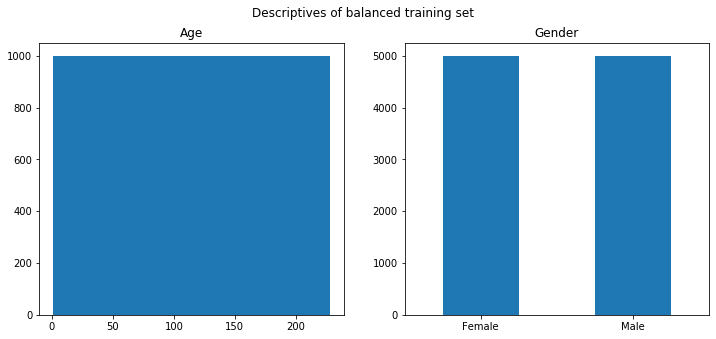

In [21]:
fig = plt.figure(figsize=(12,5)) 
fig_dims = (1, 2)
fig.suptitle('Descriptives of balanced training set')

plt.subplot2grid(fig_dims, (0, 0))
plt.hist(train['boneage'])
plt.title('Age')

plt.subplot2grid(fig_dims, (0, 1))
train['male'].value_counts().plot(kind='bar', title='Gender')
plt.xticks([True, False], ['Male', 'Female'], rotation='horizontal');